In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import seaborn.apionly as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use('ggplot')

from ipywidgets import IntSlider, interact

%load_ext autoreload
%autoreload 2

# Correlation

In this 2nd part, we will study the correlation between the mRNA and proteins relative concentrations.<br/>
We expect most of them to be correlated since the mRNA is the precursor of the protein.<br/>
Our goal is to extract uncorrelated entries for further studies.

### Loading Data

In [4]:
# Unstandardized data
prot_data_without_norm = pd.read_csv('data/data_prot.csv', index_col=0, header=[0, 1])
mRNA_data_without_norm = pd.read_csv('data/data_mRNA.csv', index_col=0, header=[0, 1])
data_without_norm = pd.read_csv('data/data.csv', index_col=0, header=[0, 1])

# Standardized data
prot_data = pd.read_csv('data/data_prot_norm.csv', index_col=0, header=[0, 1])
mRNA_data = pd.read_csv('data/data_mRNA_norm.csv', index_col=0, header=[0, 1])
data = pd.read_csv('data/data_norm.csv', index_col=0, header=[0, 1])

## 0 - First visualization

Before computing any correlation coefficients, we first visualize the evolution of levels of proteins and mRNA over time.

### a) Scatter

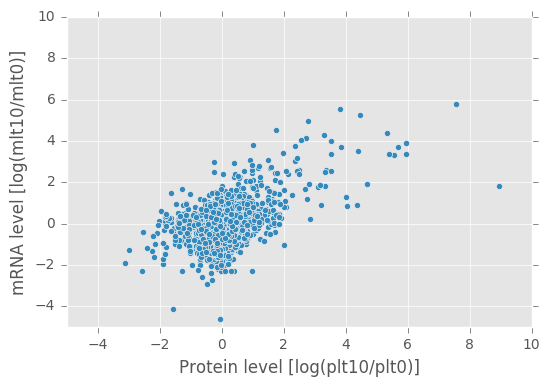

In [5]:
x_min = -5
x_max = 10
y_min = -5
y_max = 10

def plot_relation_scatter(t):
    np.log(data_without_norm).plot(kind='scatter', x=("prot", 'h'+str(t)), y=("mRNA", 'h'+str(t)))
    #data_set.plot(kind='scatter', x='t'+str(t)+'p', y='t'+str(t)+'m')
    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])
    plt.xlabel('Protein level [log(plt'+str(t)+'/plt0)]')
    plt.ylabel('mRNA level [log(mlt'+str(t)+'/mlt0)]')
    plt.show()

interact(plot_relation_scatter, t=IntSlider(min=0, max=10))

We can observe that the pattern scatters along a diagonal line, which reinforces our belief that the two data sets should be correlated.


### b) Heatmap

Another way to visualize correlations is to use heatmaps. Let's define our plot function :

In [6]:
def plot_heatmap(df, symmask=False, subplot=None):
    if symmask:
        mask_ = np.triu(np.ones(df.shape, dtype=bool),k=1) 
        ax = sns.heatmap(df, annot=True, fmt=".1f", linewidths=0.5, cbar=False, square=True, mask=mask_, ax=subplot)
        ax.set_axis_bgcolor('None')
    else:
        ax = sns.heatmap(df, annot=True, fmt=".1f", linewidths=0.5, cbar=False, square=True, ax=subplot)
    return ax

Let's compute the heatmap of correlation between all possible pair of stages :

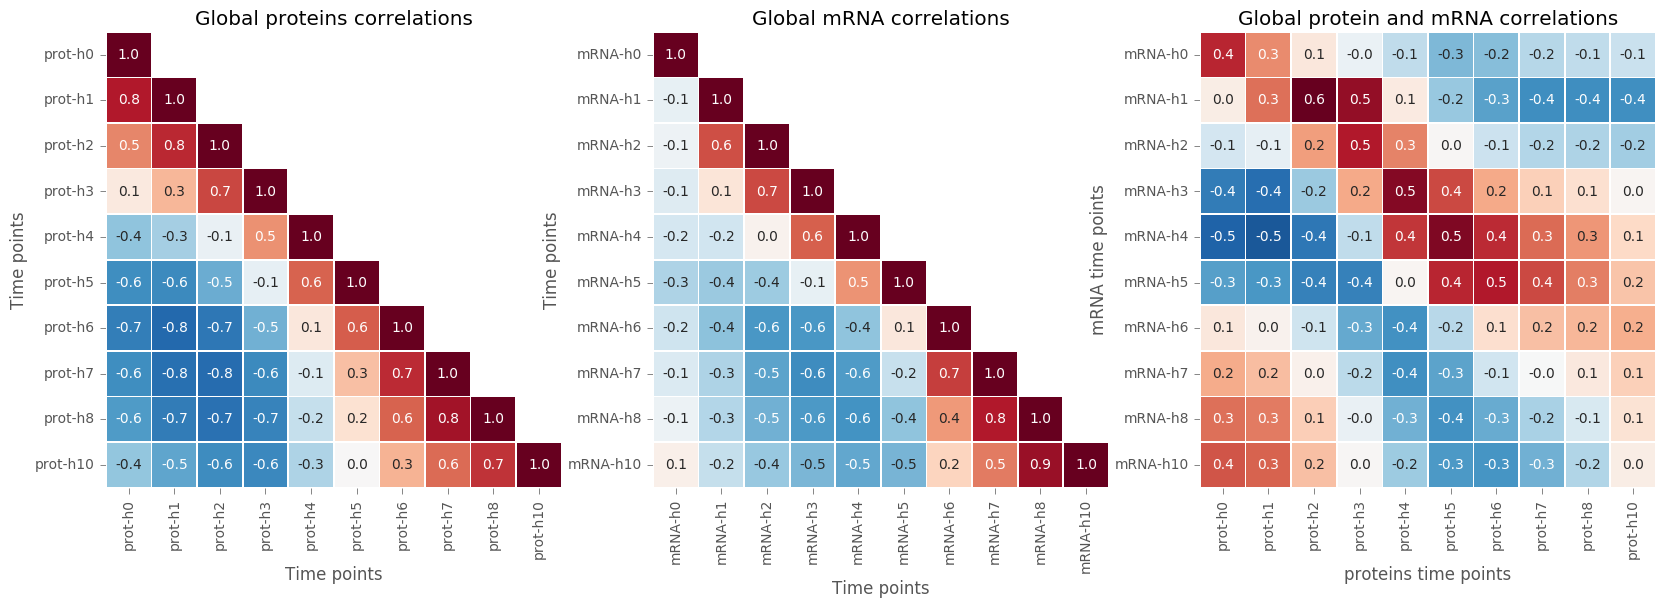

In [9]:
f, axarr = plt.subplots(1, 3, figsize=(20,15))

# Proteins
axarr[0] = plot_heatmap(prot_data.corr(), symmask=True, subplot=axarr[0])
axarr[0].set_title('Global proteins correlations')
axarr[0].set_xlabel('Time points')
axarr[0].set_ylabel('Time points')

# mRNA
axarr[1] = plot_heatmap(mRNA_data.corr(), symmask=True, subplot=axarr[1])
axarr[1].set_title('Global mRNA correlations')
axarr[1].set_xlabel('Time points')
axarr[1].set_ylabel('Time points')

# mRNA & proteins
axarr[2] = plot_heatmap(data.corr().iloc[10:22, 0:10], subplot=axarr[2])
axarr[2].set_title('Global protein and mRNA correlations')
axarr[2].set_xlabel('proteins time points')
axarr[2].set_ylabel('mRNA time points')

plt.show()

- *Global proteins correlations :* <br/>
h0 and h1 seem to be highly correlated, whereas h6, h7, h8 seem to be anti-correlated with h1, h2.
- *Global mRNA correlations :*<br/>
The heatmap looks like the proteins one. Thus, we make similar observations.
- *Global protein and mRNA correlations :*<br/>
Until we reach t=5h, the mRNA level at time t seems to be correlated with protein level at time t+1. That can be interpretated as the delay in protein synthesis.<br/>
Notice that as in our previous plots, correlation is explicit only before t(mRNA) = 5h and t(protein)=6h. It corresponds to the time of meiotic nuclear division.

## I - Pearson's correlation Analysis

We can compute the correlation using the Pearson's coefficient :
$$ \text{corr}(X,Y) = \dfrac{\text{cov}(X,Y)}{\sigma_X \sigma_Y} $$

In [11]:
def compute_corr(k):
    return prot_data.iloc[k]["prot"].corr(mRNA_data.iloc[k]["mRNA"], method='pearson')

We compute the coefficient for each mRNA/protein pair :

In [12]:
correl = np.zeros((data.shape[0],))
for k in range(data.shape[0]):
    correl[k] = compute_corr(k)

corr_ = pd.Series(correl, index=data.index)

Let's plot the result :

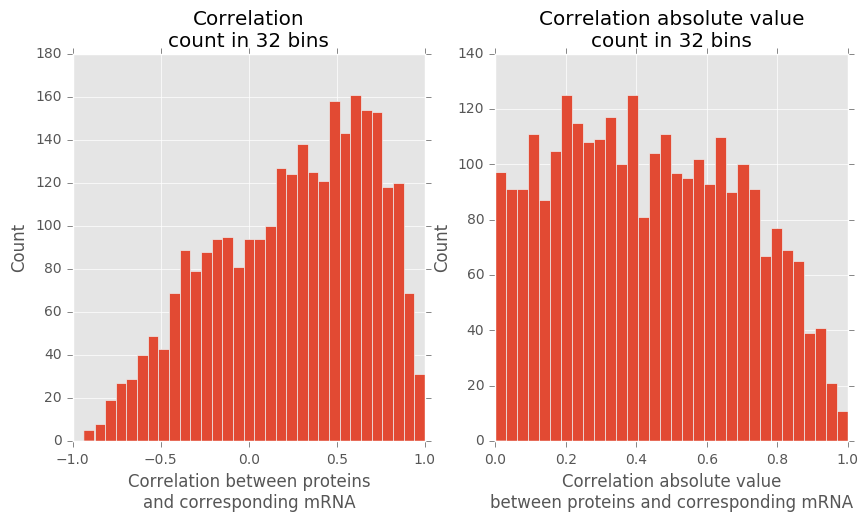

In [13]:
f, axarr = plt.subplots(1,2, figsize=(10,5))

nbins = 32

axarr[0].hist(corr_, bins=nbins)
axarr[0].set_title('Correlation\ncount in '+str(nbins)+' bins')
axarr[0].set_xlabel('Correlation between proteins\nand corresponding mRNA')
axarr[0].set_ylabel('Count')

axarr[1].hist(np.abs(corr_), bins=nbins)
axarr[1].set_title('Correlation absolute value\ncount in '+str(nbins)+' bins')
axarr[1].set_xlabel('Correlation absolute value\nbetween proteins and corresponding mRNA')
axarr[1].set_ylabel('Count')

f.subplots_adjust(hspace=2)

plt.show()

In [14]:
print("Averaged correlation : ", corr_.mean())
print("Averaged correlation in absolute value : ", np.abs(corr_).mean())

Averaged correlation :  0.241711765306549
Averaged correlation in absolute value :  0.43602073722266155


Remember that the Pearson correlation values are between **-1** and **1**.
- A correlation of **0** means that the concentrations are **uncorrelated**
- A correlation of **-1** means that the concentrations are **anticorrelated**
- A correlation of **1** means that the concentrations are **correlated**. 

On the graph, we can observe that :
- Few concentrations are anti-correlated.
- A significant number of entries are correlated.
- A lot of entries are not so clearly correlated, and even uncorrelated.

On the whole, the concentrations tends to be correlated, even if the correlation strength can vary.

## II - Concentrations evolution for various correlation degrees

Let's have a quick look at some representative of each type of correlation.<br/>
First of all, we define a plot function which enable to represent the evolution of mRNA and protein concentration for one given mRNA/protein pair.

In [10]:
def plot_set(k): # k = protein
    if type(k) == int:
        plt.plot(prot_data.iloc[k].values, label='Protein')
        plt.plot(mRNA_data.iloc[k].values, label='mRNA')
        plt.title(prot_data.index[k])
    elif type(k) == str:
        plt.plot(prot_data.loc[k].values, label='Protein')
        plt.plot(mRNA_data.loc[k].values, label='mRNA')
        plt.title(k)
    else:
        raise NameError('unrecognize input type '+str(type(k)))
    
    plt.xlabel('Time []')
    plt.ylabel('Standardized ratio')
    
    plt.legend()
    plt.show()

### a) Most correlated data

We begin with the most correlated data (coefficient close to 1).

In [12]:
corr_.sort_values().tail()

SPAC11D3.01c     0.983455
SPAC32A11.02c    0.986845
SPAC343.12       0.994239
SPBC1773.06c     0.996704
SPAC13A11.06     0.999536
dtype: float64

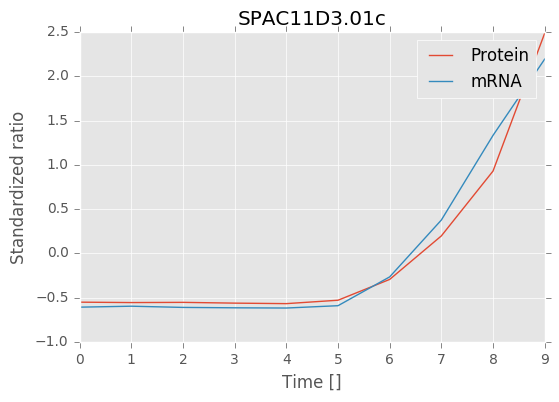

In [13]:
plot_set('SPAC11D3.01c')

In this case, the protein level exactly fits the mRNA's one. <br/>
It then seems logical that this mRNA produces this protein.

### b) Most anticorrelated data

In [14]:
corr_.sort_values().head()

SPAC227.06      -0.936494
SPBC28F2.12     -0.913948
SPCC11E10.06c   -0.896680
SPAC2F7.04      -0.894823
SPAC2G11.05c    -0.881385
dtype: float64

There are 2 possible cases of anti-correlation :
- The first one : The protein's level increases whereas the mRNA level decreases.
- The second one : The mRNA level increases whereas the protein level decreases.

- **1st case** : The protein's level increases whereas the mRNA level decreases.

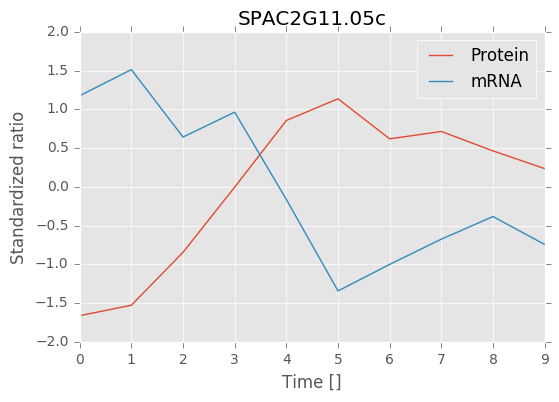

In [15]:
plot_set('SPAC2G11.05c')

One possible explanation is that, in some cases, the mRNA is destroyed when we have enough proteins (post-transcriptionnal regulation). However, the previously produced proteins are still living, and the remaining mRNA keep producing new proteins. 

- **2nd case** : The mRNA level increases whereas the protein level decreases.

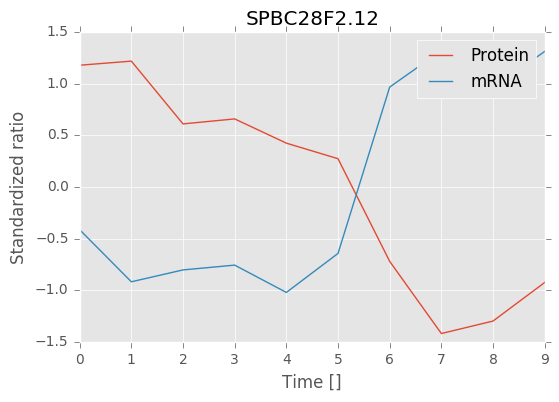

In [16]:
plot_set('SPBC28F2.12')

Again, one possible explanation could be regulatory processes : proteins or ribosomes may have been degragated and thus, the proteins level decreases.

### c) Most uncorrelated data

In [17]:
sym_thr = 0.003
corr_[np.abs(corr_) <sym_thr]

SPAC1071.04c    0.000151
SPAC17G6.04c    0.002891
SPAC1805.15c   -0.002884
SPBC713.04c     0.001140
SPCC757.08     -0.002736
SPCC962.01      0.001188
dtype: float64

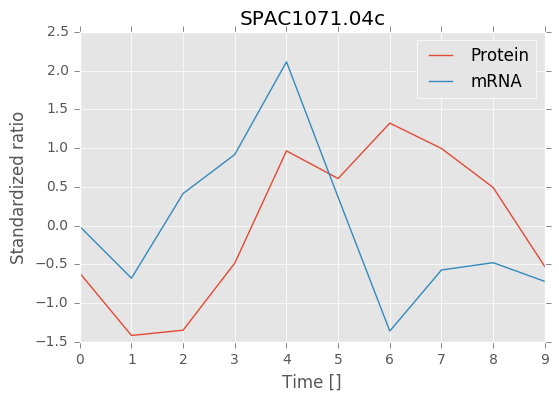

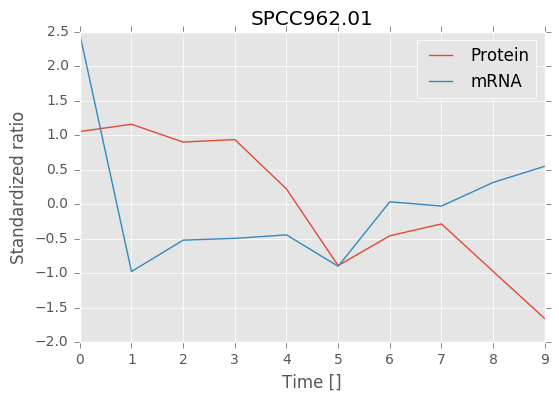

(None, None)

In [19]:
plot_set('SPAC1071.04c'), plot_set('SPCC962.01')

The first plot isn't really strange.<br/>
The second is a bit more particular.

### d) For common data

The averaged correlation in absolute value is 0.436.<br/>
Let's have a quick look at the correlated data with a coefficient of 0.4.

In [19]:
corr_[corr_<0.4].sort_values().tail(2)

SPBC14F5.05c     0.399605
SPAPB24D3.10c    0.399918
dtype: float64

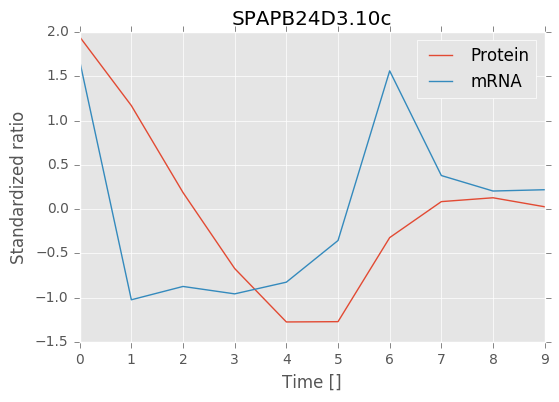

In [20]:
plot_set('SPAPB24D3.10c')

For this example of correlation coefficient of 0.4, the protein level doesn't fit the mRNA level perfectly, but the levels increase and decrease at the "same" time.

## Conclusion

Finally, at the end of this part, we've identified various correlation patterns. But we are still unable to extract uncorrelated entries. Indeed, the choice of the threshold for "uncorrelated" entries is subjective.<br/>
As our goal is to cluster uncorrelated entries, we will explore 2 solutions :
- Try to cluster the whole dataset and extract a cluster of "uncorrelated" entries
- Try to cluster the "uncorrelated" data for different threshold values.